In [28]:
from ephysvibe.structures.trials_data import TrialsData
from ephysvibe.analysis import signal,layers
import numpy as np
from ephysvibe.task import task_constants,def_task
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [24]:
path = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2023-01-26_10-45-42_Riesling_lip_e1_r1.h5'
data = TrialsData.from_python_hdf5(path)

In [23]:
trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]
if np.isnan(data.neuron_cond):
    neuron_cond = np.ones(len(data.clustersgroup))
else:
    neuron_cond = data.neuron_cond
task = def_task.create_task_frame(
    condition=data.condition[trial_idx],
    test_stimuli=data.test_stimuli[trial_idx],
    samples_cond=task_constants.SAMPLES_COND,
    neuron_cond=neuron_cond,
)
trial_in_idx=task[task['in_out']=='in']['trial_idx'].values

In [21]:
trials_s_on = data.code_samples[
    trial_idx[trial_in_idx],
    np.where(data.code_numbers[trial_idx[trial_in_idx]] == task_constants.EVENTS_B1["sample_on"])[#target_on
        1
    ],
]
t_before=500
shifts = -(trials_s_on - t_before).astype(int)
shifts = shifts[:,np.newaxis]

In [20]:
shift_lfp = TrialsData.indep_roll(data.lfp_values[trial_idx[trial_in_idx]], shifts, axis=2)
shift_sp = TrialsData.indep_roll(data.sp_samples[trial_idx[trial_in_idx]], shifts, axis=2)
inter_channel_distance=50
step=2
n_channels=shift_lfp.shape[1]


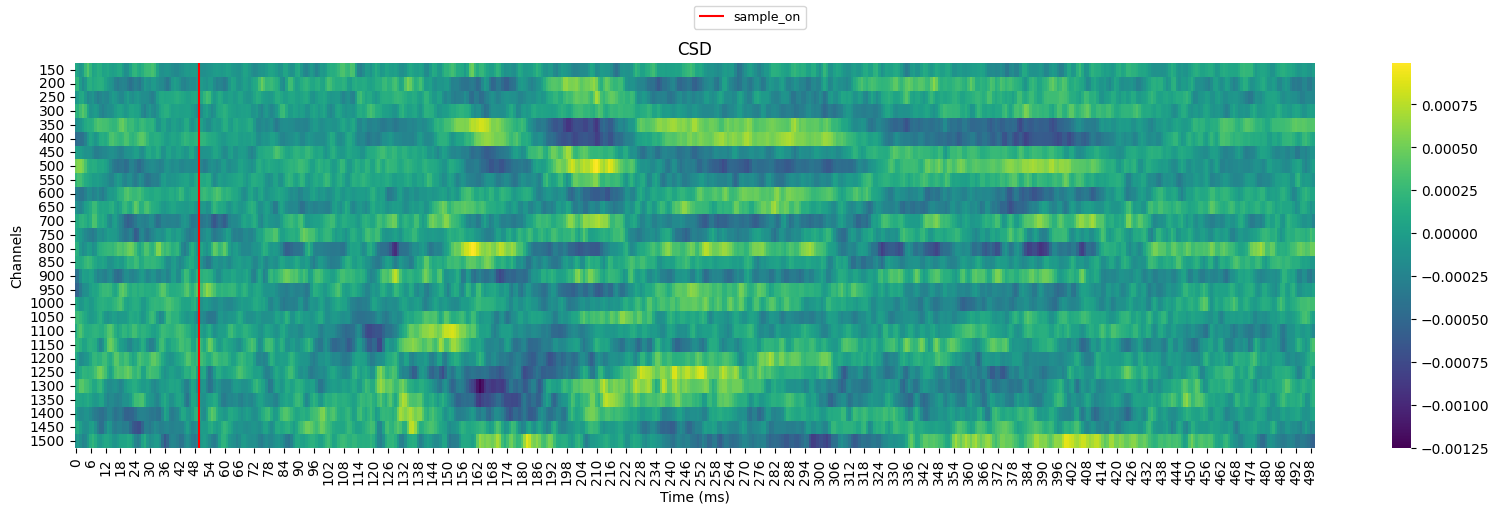

In [7]:
csd=layers.compute_csd(shift_lfp.mean(axis=0)[:,:1000], inter_channel_distance, step=step)

max_depth= inter_channel_distance*(n_channels-data.clusters_ch[0])+data.clusterdepth[0]
ch_depth = np.concatenate([np.arange(inter_channel_distance,data.clusterdepth[0],inter_channel_distance),np.arange(data.clusterdepth[0], max_depth,inter_channel_distance)])

fig, ax = plt.subplots(figsize=(20,5)) 
start_plot =  t_before-50
sns.heatmap(csd[:,start_plot:start_plot+500],cmap='viridis',ax=ax)
ax.vlines([t_before-start_plot],0,n_channels-step * 2,colors='r', label="sample_on")
fig.legend(fontsize=9,loc='upper center')
ax.set_title('CSD')
ax.set(xlabel="Time (ms)", ylabel="Channels")
ax.set_yticks(np.arange(0.5,n_channels-2*step+0.5))
a=ax.set_yticklabels(ch_depth[step:-step].astype(int), rotation=0)
#ax.set_ylabel(ch_depth[step:-step].astype(int))

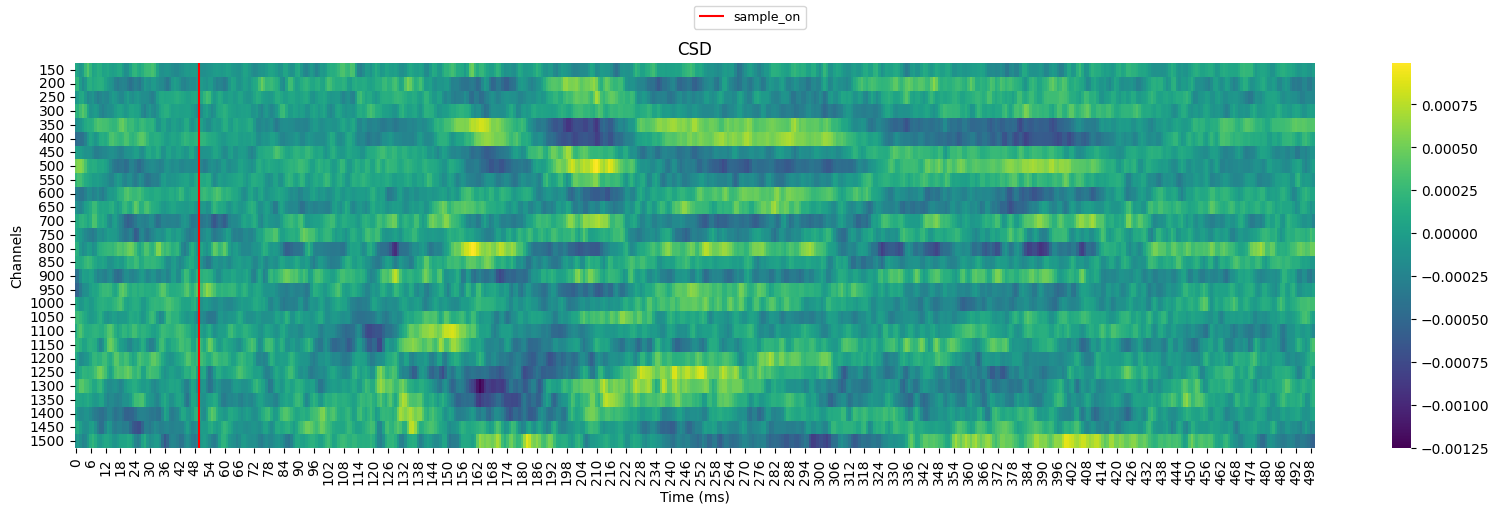

In [19]:
avg_lfp = shift_lfp[:,:,0:490].mean(axis=(2,1))
avg_shift_lfp = shift_lfp-avg_lfp[:,np.newaxis,np.newaxis]
csd_avg = layers.compute_csd(avg_shift_lfp.mean(axis=0)[:,:1000], inter_channel_distance, step=step)


max_depth= inter_channel_distance*(n_channels-data.clusters_ch[0])+data.clusterdepth[0]
ch_depth = np.concatenate([np.arange(inter_channel_distance,data.clusterdepth[0],inter_channel_distance),np.arange(data.clusterdepth[0], max_depth,inter_channel_distance)])

fig, ax = plt.subplots(figsize=(20,5)) 
start_plot =  t_before-50
sns.heatmap(csd_avg[:,start_plot:start_plot+500],cmap='viridis',ax=ax)
ax.vlines([t_before-start_plot],0,n_channels-step * 2,colors='r', label="sample_on")
fig.legend(fontsize=9,loc='upper center')
ax.set_title('CSD')
ax.set(xlabel="Time (ms)", ylabel="Channels")
ax.set_yticks(np.arange(0.5,n_channels-2*step+0.5))
a=ax.set_yticklabels(ch_depth[step:-step].astype(int), rotation=0)
#ax.set_ylabel(ch_depth[step:-step].astype(int))

In [34]:
del a
plt.close(fig)
gc.collect()

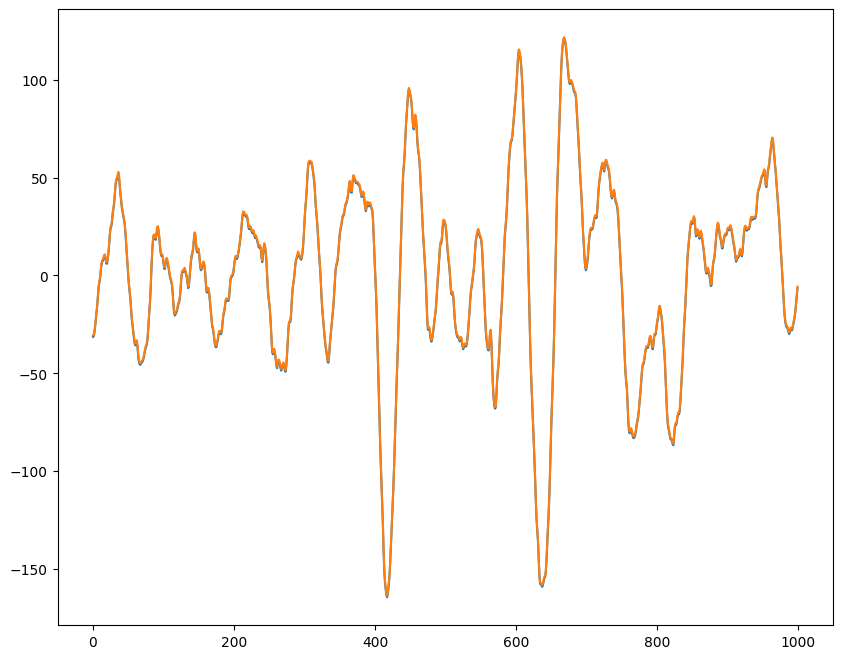

In [9]:
fig,ax = plt.subplots(figsize=(10,8))
a=ax.plot(avg_shift_lfp.mean(axis=0)[0,:1000].T)#+np.arange(0,32*100,100))
a=ax.plot(shift_lfp.mean(axis=0)[0,:1000].T)#+np.arange(0,32*100,100),'--')

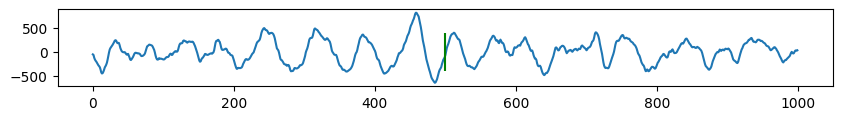

In [10]:
median_ch = np.median(shift_lfp,axis=1)
lfp_median_correction = shift_lfp-median_ch[:,np.newaxis,:]
fig,ax = plt.subplots(figsize=(10,1))
a=ax.plot(median_ch[0,:1000])
ax.vlines([t_before],-400,400,colors=['g'])

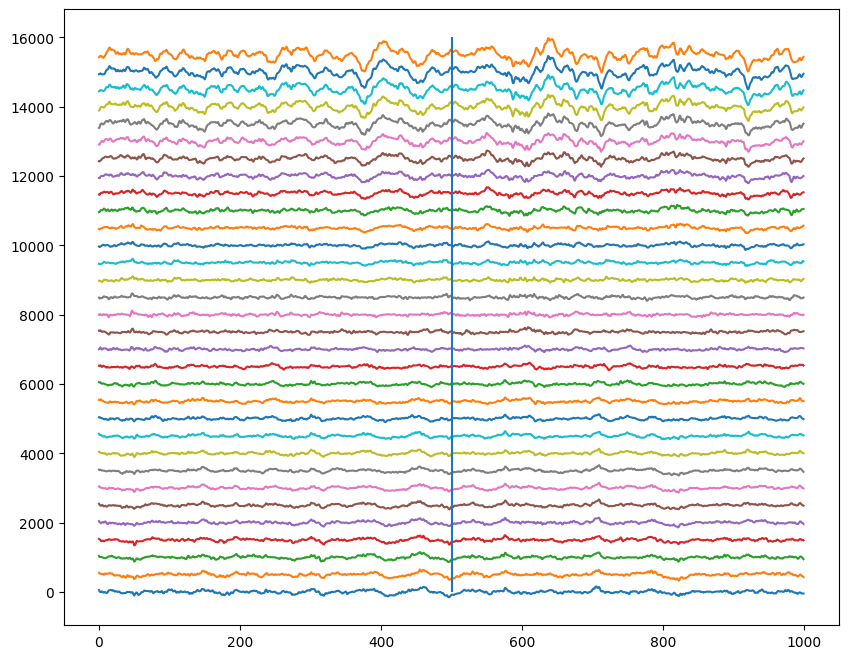

In [11]:
fig,ax = plt.subplots(figsize=(10,8))
a=ax.plot(lfp_median_correction[0,:,:1000].T+np.arange(0,32*500,500))
ax.vlines([t_before],0,32*500)

In [12]:
from mne import time_frequency
from scipy.fft import fft,fftfreq

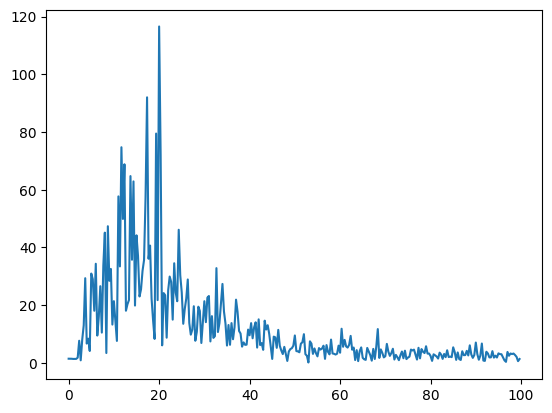

In [13]:
x=shift_lfp[5,29,:3000]
N=x.shape[0]
T = 1/1000
x0=fft(x,N,axis=0)
xf = fftfreq(N, T)[:N//10]
plt.plot(xf, 2.0/N * np.abs(x0[0:N//10]))

Effective window size : 0.256 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s finished


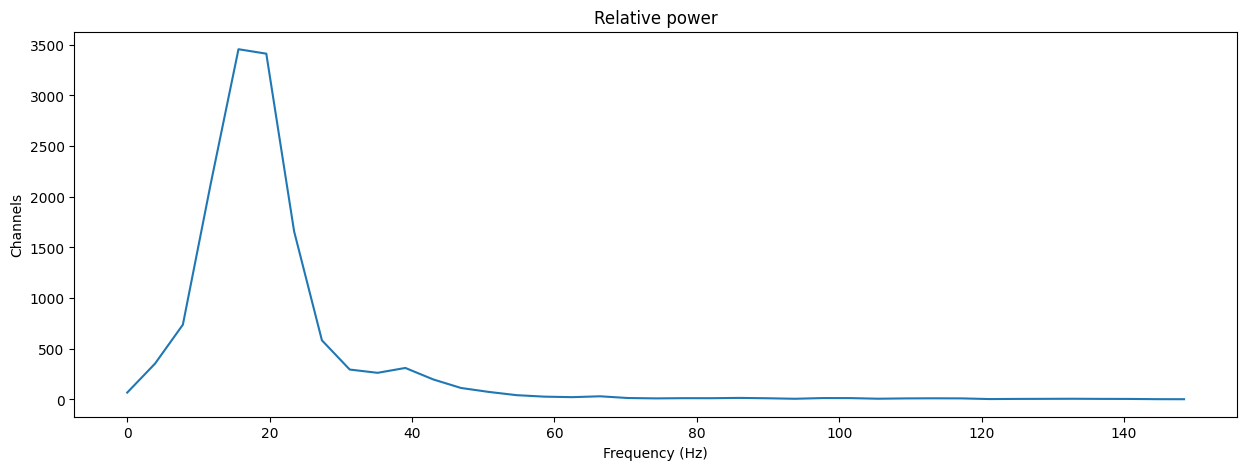

In [14]:
x=shift_lfp[:,:,:1000]
fmax=150
s_freq = 1000
w_size = 200
psd, freqs = time_frequency.psd_array_welch(
            x, fmax=fmax, sfreq=s_freq, n_per_seg=w_size
        )
# Plot RP
_,ax = plt.subplots(figsize=(15,5))
a=ax.plot(freqs,psd[0,30].T)
ax.set_title("Relative power")
ax.set(xlabel="Frequency (Hz)", ylabel="Channels")
# ax.set_yticks(np.flip(np.arange(0.5, n_channels  + 0.5)))
# ax.set_yticklabels(ch_depth.astype(int), rotation=0)

plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows


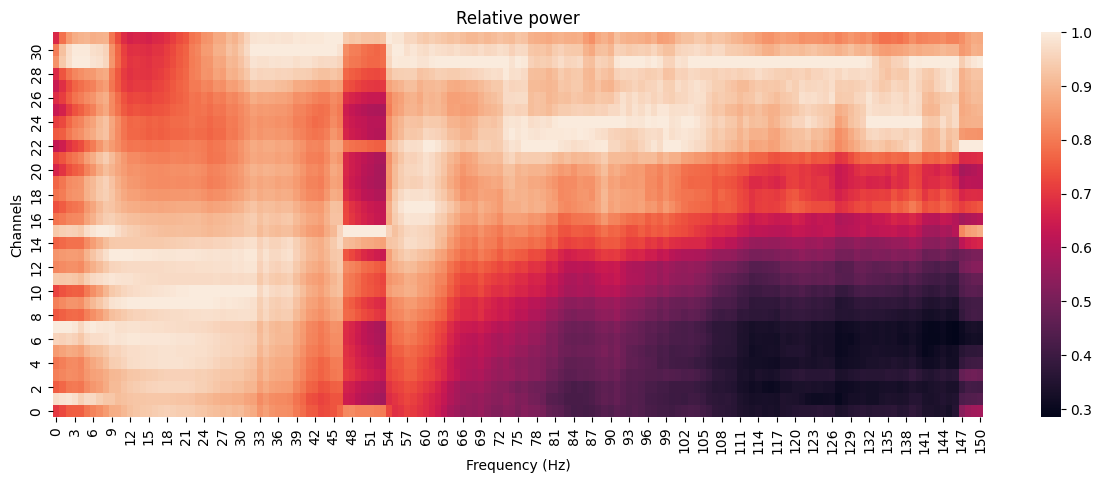

In [15]:
fmax=150
s_freq = 1000
w_size = 200
x=shift_lfp[:,:,:1000]
avg_psd,freqs = signal.compute_relative_power(x,psd_method='multitaper',fmax=150,s_freq = s_freq,w_size = w_size)
# Plot RP
_,ax = plt.subplots(figsize=(15,5))
sns.heatmap(avg_psd)
ax.set_title("Relative power")
ax.set(xlabel="Frequency (Hz)", ylabel="Channels")
# ax.set_yticks(np.flip(np.arange(0.5, n_channels  + 0.5)))
# ax.set_yticklabels(ch_depth.astype(int), rotation=0)
ax.invert_yaxis()
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows


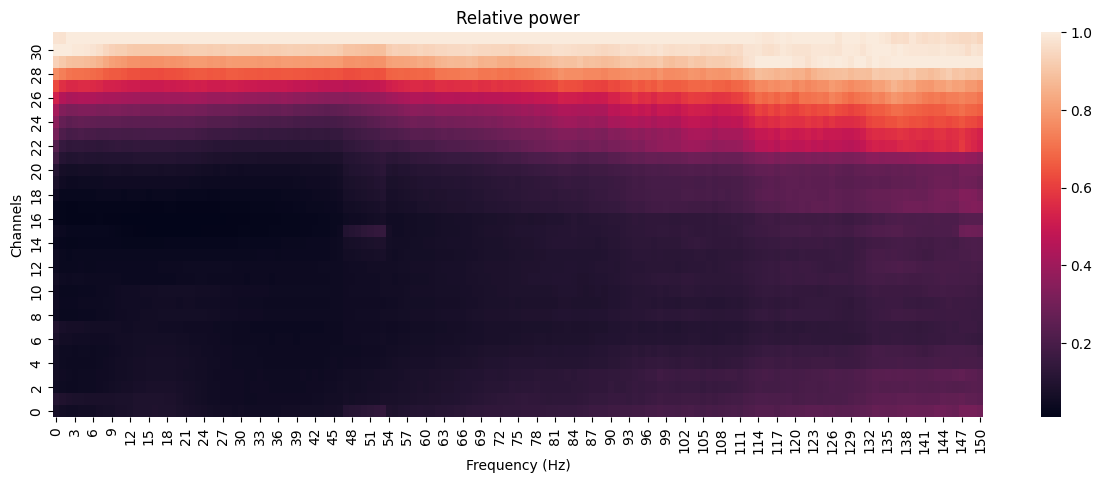

In [16]:
x=lfp_median_correction[:,:,:1000]#

avg_psd_median,freqs_median = signal.compute_relative_power(x,psd_method='multitaper',fmax=150,s_freq = s_freq,w_size = w_size)

# # Plot RP
# _,ax = plt.subplots(figsize=(15,5))
# sns.heatmap(avg_psd_median)
# ax.invert_yaxis()
# plt.show()

_,ax = plt.subplots(figsize=(15,5))
sns.heatmap(avg_psd_median)
ax.set_title("Relative power")
ax.set(xlabel="Frequency (Hz)", ylabel="Channels")
# ax.set_yticks(np.flip(np.arange(0.5, n_channels  + 0.5)))
# ax.set_yticklabels(ch_depth.astype(int), rotation=0)
ax.invert_yaxis()
plt.show()

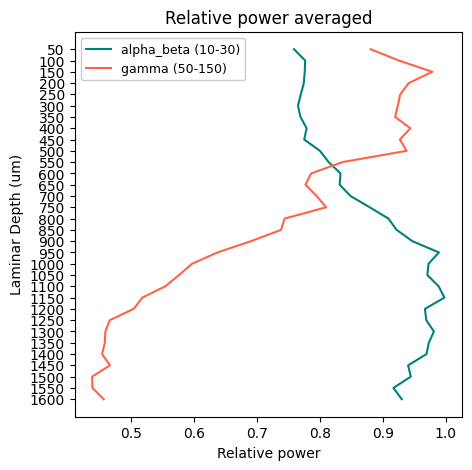

In [17]:
# compute relative power maps
rp_alpha_beta = avg_psd[:, np.where(np.logical_and(freqs > 10, freqs < 30))[0]]
rp_gamma = avg_psd[:, np.where(np.logical_and(freqs > 50, freqs < 150))[0]]
# Plot
fig,ax = plt.subplots(figsize=(5,5))
a=ax.plot(rp_alpha_beta.mean(axis=1),np.arange(0,32),label='alpha_beta (10-30)',color='teal')
a=ax.plot(rp_gamma.mean(axis=1),np.arange(0,32),label='gamma (50-150)',color='tomato')
a=ax.set_yticks(np.arange(0,32))
ax.legend(fontsize=9,columnspacing=0.5,facecolor='white', framealpha=1,loc='upper left')
ax.set_title("Relative power averaged")
ax.set(xlabel="Relative power", ylabel="Laminar Depth (um)")
ax.set_yticks(np.flip(np.arange(0, n_channels)))
a=ax.set_yticklabels(ch_depth.astype(int), rotation=0)